In [3]:
# Set up the environment¶

import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session

sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_session.region_name

role = get_execution_role()

In [4]:
#Download the MNIST dataset¶

import utils
from tensorflow.contrib.learn.python.learn.datasets import mnist
import tensorflow as tf

data_sets = mnist.read_data_sets('data', dtype=tf.uint8, reshape=False, validation_size=5000)

utils.convert_to(data_sets.train, 'train', 'data')
utils.convert_to(data_sets.validation, 'validation', 'data')
utils.convert_to(data_sets.test, 'test', 'data')

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Writing data/train.tfrecords
Writing data/validation.tfrecords
Writing data/test.tfrecords


In [6]:
# Upload the data¶

inputs = sagemaker_session.upload_data(path='data', key_prefix='data/DEMO-mnist')

In [7]:
# Construct a script for distributed training

!cat 'mnist.py'

import os
import tensorflow as tf
from tensorflow.python.estimator.model_fn import ModeKeys as Modes

INPUT_TENSOR_NAME = 'inputs'
SIGNATURE_NAME = 'predictions'

LEARNING_RATE = 0.001


def model_fn(features, labels, mode, params):
    # Input Layer
    input_layer = tf.reshape(features[INPUT_TENSOR_NAME], [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding='same',
        activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding='same',
        activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.d

In [ ]:
# Create an estimator

from sagemaker.tensorflow import TensorFlow

mnist_estimator = TensorFlow(entry_point='mnist.py',
                             role=role,
                             framework_version='1.12.0',
                             training_steps=1000, 
                             evaluation_steps=100,
                             train_instance_count=2,
                             train_instance_type='ml.c4.xlarge')

mnist_estimator.fit(inputs)

tensorflow py2 container will be deprecated soon.


2019-12-24 23:31:40 Starting - Starting the training job...
2019-12-24 23:31:42 Starting - Launching requested ML instances.....

In [9]:
# SageMaker's transformer class

transformer = mnist_estimator.transformer(instance_count=1, instance_type='ml.m4.xlarge')

The Python 2 tensorflow images will be soon deprecated and may not be supported for newer upcoming versions of the tensorflow images.
Please set the argument "py_version='py3'" to use the Python 3 tensorflow image.


In [10]:
# Run a batch transform job

input_bucket_name = 'sagemaker-sample-data-{}'.format(region)
input_file_path = 'batch-transform/mnist-1000-samples'

transformer.transform('s3://{}/{}'.format(input_bucket_name, input_file_path), content_type='text/csv')

transformer.wait()

...................2019-12-25 00:03:45,785 INFO - root - running container entrypoint
2019-12-25 00:03:45,785 INFO - root - starting serve task
2019-12-25 00:03:45,786 INFO - container_support.serving - reading config
2019-12-25 00:03:46,094 INFO - container_support.serving - importing user module
2019-12-25 00:03:46,094 INFO - container_support.serving - loading framework-specific dependencies
2019-12-25 00:03:47,498 INFO - container_support.serving - starting nginx
2019-12-25 00:03:47,498 INFO - container_support.serving - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log /var/log/nginx/error.log;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /var/log/nginx/access.log combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    locat

In [9]:
# Download the results

print(transformer.output_path)

# Now let's download the first ten results from S3:

import json
from six.moves.urllib import parse

import boto3

parsed_url = parse.urlparse(transformer.output_path)
bucket_name = parsed_url.netloc
prefix = parsed_url.path[1:]

s3 = boto3.resource('s3')

predictions = []
for i in range(10):
    file_key = '{}/data-{}.csv.out'.format(prefix, i)

    output_obj = s3.Object(bucket_name, file_key)
    output = output_obj.get()["Body"].read().decode('utf-8')

    predictions.extend(json.loads(output)['outputs']['classes']['int64Val'])

s3://sagemaker-us-east-2-371990375707/sagemaker-tensorflow-2019-12-24-00-47-5-2019-12-24-00-53-17-099


7, 2, 1, 0, 4, 1, 4, 9, 5, 9


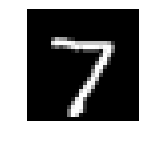

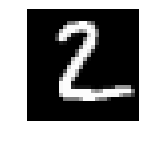

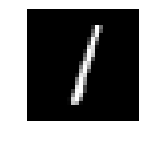

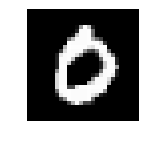

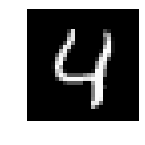

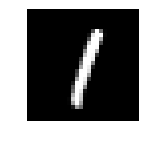

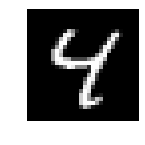

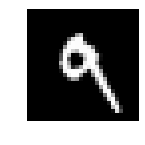

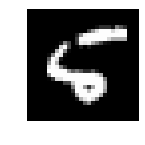

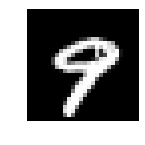

In [11]:
# For demonstration purposes, we're also going to download the corresponding original input data so that we can see how the model did with its predictions.

import os

import matplotlib.pyplot as plt
from numpy import genfromtxt

plt.rcParams['figure.figsize'] = (2,10)

def show_digit(img, caption='', subplot=None):
    if subplot == None:
        _,(subplot) = plt.subplots(1,1)
    imgr = img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

tmp_dir = '/tmp/data'
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

for i in range(10):
    input_file_name = 'data-{}.csv'.format(i)
    input_file_key = '{}/{}'.format(input_file_path, input_file_name)
    
    s3.Bucket(input_bucket_name).download_file(input_file_key, os.path.join(tmp_dir, input_file_name))
    input_data = genfromtxt(os.path.join(tmp_dir, input_file_name), delimiter=',')

    show_digit(input_data)
    

print(', '.join(predictions))